In [7]:
import math
import torch
from torch import nn
from d2l import torch as d2l

In [8]:
# 非所有的值都应该被纳入到注意力汇聚中
# 为了仅将有意义的词元作为值来获取注意力汇聚， 可以指定一个有效序列长度（即词元的个数）
def masked_softmax(X: torch.Tensor, valid_lens: torch.Tensor):
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # 最后一轴上被掩蔽的元素使用一个非常大的负值替换，从而其softmax输出为0
        X = d2l.sequence_mask(X.reshape(-1, shape[-1]), valid_lens,
                              value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [9]:
# 注意：softmax计算的结果为权重矩阵。
# valid_lens[i]表示第i个批量中，只有前valid_lens[i]个key是有效的  
masked_softmax(torch.rand(2,2,4), torch.tensor([2,3]))

tensor([[[0.4098, 0.5902, 0.0000, 0.0000],
         [0.4620, 0.5380, 0.0000, 0.0000]],

        [[0.4179, 0.2386, 0.3434, 0.0000],
         [0.2897, 0.2654, 0.4449, 0.0000]]])

## 1 当查询和键是不同长度的矢量时，可以使用加性注意力作为评分函数
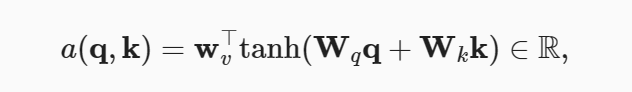

In [10]:
class AdditiveAttention(nn.Module):
    """加性注意力"""
    # num_hiddens表示该隐藏层的维度，维度越大表示 "能力越强"
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # 在维度扩展后（维度扩展前不满足广播条件）
        # queries的形状：(batch_size，查询的个数，1，num_hidden)
        # key的形状：(batch_size，1，“键－值”对的个数，num_hiddens)
        # 使用广播方式进行求和
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # self.w_v仅有一个输出，因此从形状中移除最后那个维度。
        # scores的形状：(batch_size，查询的个数，“键-值”对的个数)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # values的形状：(batch_size，“键－值”对的个数，值的维度)
        # 还要注意bmm不是普通的矩阵乘法，而是批量矩阵乘法
        # 
        return torch.bmm(self.dropout(self.attention_weights), values)

关于 torch squeeze 和 unsqueeze 函数的小总结
- squeeze：torch.squeeze()函数的作用减少数组A指定位置N的维度，如果不指定位置参数N，如果数组A的维度为（1，1，3）那么执行 torch.squeeze(A，1) 后A的维度变为 （1，3），中间的维度被删除
  - 如果指定的维度大于1，那么将操作无效
  - 如果不指定维度N，那么将删除所有维度为1的维度
- unsqueeze：torch.unsqueeze()函数的作用增加数组A指定位置N的维度，例如两行三列的数组A维度为(2，3)，那么这个数组就有三个位置可以增加维度，分别是（ [位置0] 2，[位置1] 3 [位置2] ）或者是 （ [位置-3] 2，[位置-2] 3 [位置-1] ），如果执行 torch.unsqueeze(A，1)，数据的维度就变为了 （2，1，3）

关于python的可变参数小总结

对于函数参数
- 单星号（*）：*agrs： 将所有参数以元组(tuple)的形式导入
- 双星号（\*\*）：\*\*kwargs: 双星号（**）将参数以字典的形式导入

对于解包
- 单星号：用于解包list，tuple
- 双星号：用于解包字典，常用于将字典的key-value对转换为函数的参数
```python
def foo(param1, *param2):
    print (param1)
    print (param2)
foo(1,2,3,4,5)
1
(2, 3, 4, 5)


def bar(param1, **param2):
    print (param1)
    print (param2)
bar(1,a=2,b=3)
1
{'a': 2, 'b': 3}

In [11]:
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
# values的小批量，两个值矩阵是相同的
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(
    2, 1, 1)
valid_lens = torch.tensor([2, 6])

attention = AdditiveAttention(key_size=2, 
                              query_size=20, 
                              num_hiddens=8,
                              dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

## 2. 当查询和键的维度相同时，可以使用缩放点积注意力评分函数

$$
a(\mathbf{q}, \mathbf{k}) = \mathbf{q}^\top \mathbf{k} / \sqrt{d}
$$
最终输出的形状为：(batch_size, query_num, key-value_num)

下面的实现为支持批处理的计算方法

In [12]:
# 支持批量处理的Attention
class DotProductAttention(nn.Module):
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
    # 对于公示的要求查询和键的维度必须相同
    # Q: (batch_size, query_num, d)
    # K: (batch_size, key-value_num, d)
    # V: (batch_size, key-value_num, 值的维度)
    def forward(self, queries: torch.Tensor, keys: torch.Tensor, values: torch.Tensor, 
                valid_len=None):
        d = queries.shape[-1]
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

浅析`masked_softmax`中，`valid_lens`参数的作用:

注意力分数计算的结果`attention_weights`是一个3D的张量，形状为`(batch_size, query_num, key-value_num)`. `valid_lens` 的作用：第i个批量中，只有前`valid_lens[i]个key`参与注意力计算，后8个键的权重被掩码。对应到`attention_weights`中， 只有`[i,:,:valid_lens[i]]`会被`soft_max`赋值有效权重，后面的权重全为0.


In [13]:
queries = torch.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])